In [1]:
from sys import path as syspath
from os import path as ospath
import pickle

syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))

from cbsa import ReactionSystem

import cbsa2models

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def switch_time_gaps(data):
    tf_str = "".join([str(int(data[i,1])) for i in range(data.shape[0])])
    tf_steps = [step.split("10") for step in tf_str.split("01")]
    tf_steps  = [len(item)+2 for sublist in tf_steps  for item in sublist]
    tf_steps[0] -= 1
    tf_steps[-1] -= 1
    cumsum = [0]+list(np.cumsum(tf_steps))
    time_steps = np.diff(data[:,0])
    tf_times = {0:[],1:[]}
    value = 0
    for i in range(1,len(cumsum)):
        time = np.sum(time_steps[cumsum[i-1]:cumsum[i]])
        tf_times[value].append(time)
        if value:
            value = 0
        else:
            value = 1
    return tf_times


def mean_value(data,index,time=None):
    time_index = data.shape[0]
    if time:
        time_index = np.searchsorted(data[:,0],time,side="left")
    time_steps = np.diff(data[:time_index,0])
    sum_ts = np.sum(time_steps)
    if not sum_ts: return 0.
    return np.sum(time_steps*data[:time_index,index][0:-1])/sum_ts


In [3]:
total_sim_time = 100000

cbsa = cbsa2models.generate_cbsa_burst_model(total_sim_time=total_sim_time)

In [4]:
cbsa.setup_simulation(use_opencl=False)
cbsa.compute_simulation(total_sim_time,batch_steps=1)
cbsa_data = np.array(cbsa.simulation_data)

with open("cbsa_burst_0.5_0.5_200_0.5.pdata","wb") as f:
    pickle.dump(cbsa_data,f)

In [5]:
cbsa_data = pickle.load( open( "cbsa_burst_0.5_0.5_200_0.5.pdata", "rb" ) )
cbsa_switch_times = switch_time_gaps(cbsa_data)
cbsa_times = np.linspace(0.,cbsa_data[-1,0],5000)
cbsa_mean_values_Eact = [mean_value(cbsa_data,1,i) for i in cbsa_times]
cbsa_mean_values_Mol = [mean_value(cbsa_data,3,i) for i in cbsa_times]

In [6]:
from matplotlib import rc
fontsize = 14
rc('text', usetex=True)
plt.style.use("bmh")
plt.rcParams["font.family"] = "serif"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


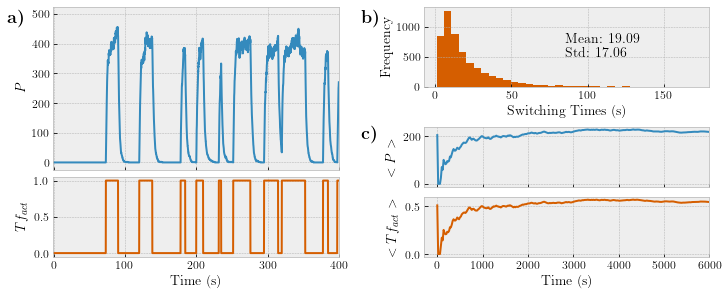

In [15]:


fig = plt.figure(figsize=(10, 4),constrained_layout=True)

gs = fig.add_gridspec(nrows=10, ncols=2)


ax0 = fig.add_subplot(gs[0:6,0:1])
ax1 = fig.add_subplot(gs[6:10,0:1])
ax2 = fig.add_subplot(gs[0:4,1:2])
ax3 = fig.add_subplot(gs[4:7,1:2])
ax4 = fig.add_subplot(gs[7:10,1:2])


ax0.plot(cbsa_data[:,0],cbsa_data[:,3],color=colors[0])
ax0.set_xlim(-1,400)
ax0.set_xticklabels([])
ax0.set_ylabel("$P$",fontsize=fontsize)
ax0.text(-0.16,0.9,r'\textbf{a)}', transform=ax0.transAxes,fontsize=18)

ax1.plot(cbsa_data[:,0],cbsa_data[:,1],color=colors[4])
ax1.set_xlim(-1,400)
ax1.set_xlabel("Time (s)",fontsize=fontsize)
ax1.set_ylabel("$Tf_{act}$",fontsize=fontsize)

ax2.hist(cbsa_switch_times[0]+cbsa_switch_times[1],bins=35,color=colors[4])
ax2.set_xlabel("Switching Times (s)",fontsize=fontsize)
ax2.set_ylabel("Frequency",fontsize=fontsize)
ax2.text(85,500,"Mean: "+str(np.round(np.mean(cbsa_switch_times[0]+cbsa_switch_times[1]),2))+"\nStd: "+str(np.round(np.std(cbsa_switch_times[0]+cbsa_switch_times[1]),2)),fontsize=fontsize)
ax2.text(-0.22,0.8,r'\textbf{b)}', transform=ax2.transAxes,fontsize=18)

ax3.plot(cbsa_times,cbsa_mean_values_Mol,color=colors[0])
ax3.set_xticklabels([])
ax3.set_ylabel("$<P>$",fontsize=fontsize)
ax3.text(-0.22,0.8,r'\textbf{c)}', transform=ax3.transAxes,fontsize=18)
ax3.set_xlim(-300,6000)
#ax3.set_ylim(0,np.max(np.array(cbsa_mean_values_Mol))*1.1)

ax4.plot(cbsa_times,cbsa_mean_values_Eact,color=colors[4])
ax4.set_xlabel("Time (s)",fontsize=fontsize)
ax4.set_ylabel("$<Tf_{act}>$",fontsize=fontsize)
ax4.set_xlim(-300,6000)
#ax4.set_ylim(0,np.max(np.array(cbsa_mean_values_Eact))*1.1)
#ax4.set_yticks([0.,0.5])

plt.savefig("burst.png",dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def run_stochpy(cbsa_model,method="Direct"):
    smod = cbsa2models.cbsa2stochpy(cbsa_model)
    smod.DoStochSim(method=method,mode='time',end=cbsa_model.bench_total_sim_time,trajectories=1)
    return smod.data_stochsim.getSpecies()

def run_stochpy_ssa(cbsa_model):
    return run_stochpy(cbsa_model)

def run_stochpy_tauleap(cbsa_model):
    return run_stochpy(cbsa_model,method="Tauleap")

In [9]:
ssa_data = run_stochpy_ssa(cbsa)
with open("stochpy_ssa_burst_0.05_0.05_200_0.5.pdata","wb") as f:
    pickle.dump(ssa_data,f)
tauleap_data = run_stochpy_tauleap(cbsa)
with open("stochpy_tauleap_burst_0.05_0.05_200_0.5.pdata","wb") as f:
    pickle.dump(tauleap_data,f)



#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

/home/burke/.local/lib/python3.7/site-packages/stochpy/implementations/TauLeaping.py:217: RuntimeWarning: All-NaN slice encountered
  minima = np.nanmin(output,axis=1)


In [10]:
ssa_data = pickle.load( open( "stochpy_ssa_burst_0.05_0.05_200_0.5.pdata", "rb" ) )
ssa_switch_times = switch_time_gaps(ssa_data)
ssa_times = np.linspace(0.,ssa_data[-1,0],5000)
ssa_mean_values_Eact = [mean_value(ssa_data,1,i) for i in ssa_times]
ssa_mean_values_Mol = [mean_value(ssa_data,3,i) for i in ssa_times]

tauleap_data = pickle.load( open( "stochpy_tauleap_burst_0.05_0.05_200_0.5.pdata", "rb" ) )
tauleap_switch_times = switch_time_gaps(tauleap_data)
tauleap_times = np.linspace(0.,tauleap_data[-1,0],5000)
tauleap_mean_values_Eact = [mean_value(tauleap_data,1,i) for i in tauleap_times]
tauleap_mean_values_Mol = [mean_value(tauleap_data,3,i) for i in tauleap_times]

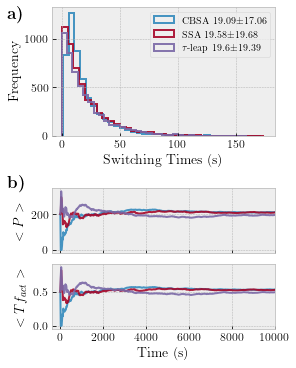

In [11]:
fig = plt.figure(figsize=(4, 5),constrained_layout=True)

gs = fig.add_gridspec(nrows=4, ncols=1)


ax0 = fig.add_subplot(gs[0:2])
ax1 = fig.add_subplot(gs[2])
ax2 = fig.add_subplot(gs[3])

bins = 35
ax0.hist(cbsa_switch_times[0]+cbsa_switch_times[1],bins=bins,alpha=0.9,histtype='step',label=r'CBSA $'+str(np.round(np.mean(cbsa_switch_times[0]+cbsa_switch_times[1]),2))+r'\pm$'+str(np.round(np.std(cbsa_switch_times[0]+cbsa_switch_times[1]),2)),linewidth=2)
ax0.hist(ssa_switch_times[0]+ssa_switch_times[1],bins=bins,alpha=0.9,histtype='step',label=r'SSA $'+str(np.round(np.mean(ssa_switch_times[0]+ssa_switch_times[1]),2))+r'\pm$'+str(np.round(np.std(ssa_switch_times[0]+ssa_switch_times[1]),2)),linewidth=2)
ax0.hist(tauleap_switch_times[0]+tauleap_switch_times[1],bins=bins,alpha=0.9,histtype='step',label=r'$\tau$-leap $'+str(np.round(np.mean(tauleap_switch_times[0]+tauleap_switch_times[1]),2))+r'\pm$'+str(np.round(np.std(tauleap_switch_times[0]+tauleap_switch_times[1]),2)),linewidth=2)
ax0.set_ylabel("Frequency",fontsize=fontsize)
ax0.set_xlabel("Switching Times (s)",fontsize=fontsize)
ax0.text(-0.2,0.9,r'\textbf{a)}', transform=ax0.transAxes,fontsize=17)
ax0.legend(loc="upper right")

ax1.plot(cbsa_times,cbsa_mean_values_Mol,alpha=0.9)
ax1.plot(ssa_times,ssa_mean_values_Mol,alpha=0.9)
ax1.plot(tauleap_times,tauleap_mean_values_Mol,alpha=0.9)
ax1.set_xticklabels([])
ax1.set_ylabel("$<P>$",fontsize=fontsize)
ax1.text(-0.2,1,r'\textbf{b)}', transform=ax1.transAxes,fontsize=17)
ax1.set_xlim(-400,10000)

ax2.plot(cbsa_times,cbsa_mean_values_Eact,alpha=0.9)
ax2.plot(ssa_times,ssa_mean_values_Eact,alpha=0.9)
ax2.plot(tauleap_times,tauleap_mean_values_Eact,alpha=0.9)
ax2.set_xlabel("Time (s)",fontsize=fontsize)
ax2.set_ylabel("$<Tf_{act}>$",fontsize=fontsize)
ax2.set_xlim(-400,10000)


plt.savefig("burst_ssa_validation.png",dpi=300, bbox_inches='tight')
plt.show()